In [4]:
import numpy as np

from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

# load a test model

noise_list = np.linspace(0.025, 0.25, 10)
fname_list = np.array(['./noisy_models/salt_noise='+str(noise)+'--pep_noise='+str(noise)+'.h5' for noise in noise_list])
model_list = np.array([load_model(fname) for fname in fname_list])


In [441]:
clean_model = load_model('./math276/nick_noisy_models/salt_noise=0--pep_noise=0.h5')


In [16]:
# Given an array of weights, calculate the pairwise geometric mean and sum over it


def wedge_cluster(node, norm = 1):
    m = norm # maximum value
    
    node = node/m  # "normalize" the vector

    nodeMat = np.outer(node, node) # Compute the outer product

    nodeMat = nodeMat - np.diag(np.diag(nodeMat)) # subtract off the diagonal

    sqrtArr = np.sqrt(np.abs(nodeMat.flatten())) # flatten and take the square root

    return 2* np.sum(sqrtArr)/(2* node.size * (node.size - 1)) # normalize properly

def wedge_local(weights):
    return np.array([wedge_cluster(node, norm = np.max(np.abs(node))) for node in weights])

def wedge_global(weights):
    m = np.max(np.abs(weights))
    return np.array([wedge_cluster(node, norm = m) for node in weights])

def quad_coeff(in_weights, out_weights, norm_in = 0, norm_out = 0):

    n_in = in_weights.shape[0]
    n = in_weights.shape[1]
    n_out = out_weights.shape[1]
    motif_poss = (n_in)*(n_out)*(n-1)

    # Default norm is the respective layer norms
    if (norm_out * norm_in == 0):
        norm_in = np.max(np.abs(in_weights))
        norm_out = np.max(np.abs(out_weights))
    
    # normalize the weights
    in_weights = in_weights/norm_in
    out_weights = out_weights/norm_out
    
    # transform entries to be to the 1/4th power
    in_weights = np.power(np.abs(in_weights), .25)
    out_weights = np.power(np.abs(out_weights), .25)
  
    # Caclulate A^t.A and B.B^t
    in_matrix = np.matmul(in_weights.T, in_weights)
    out_matrix = np.matmul(out_weights, out_weights.T)
    
    # subtract off the diagonals
    in_matrix = in_matrix - np.diag(np.diag(in_matrix))
    out_matrix = out_matrix - np.diag(np.diag(out_matrix))
    
    # entry-wise multiplication
    quad_matrix = np.multiply(in_matrix, out_matrix)
    
    # Return normalized coeff
    return(1/(motif_poss) * np.sum(quad_matrix, axis = 0))
    
    

In [338]:
# cumulative stats:

def cumulative_hist(arr, title_name, label_list, x_label, y_label = "Number of Nodes"):
    plt.title(title_name)
    for (i, w) in enumerate(arr):
        plt.hist(w, 15, alpha = 0.2, label = str(label_list[i]))
    plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
          ncol=1, fancybox=True, shadow=True)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

    
def cumulative_thresh(arr, title_name, label_list, x_label = "Coeff Threshold", y_label = "Percent of nodes below threshold"):
    thresh_list = np.linspace(np.min(arr), np.max(arr))
    plt.title(title_name)
    for (i,w) in enumerate(arr):
        cumula_nodes = np.array([np.sum(w < thresh) for thresh in thresh_list])/128
        plt.plot(thresh_list, cumula_nodes, label = str(label_list[i]))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
          ncol=1, fancybox=True, shadow=True)
    plt.show()
    

def max_vals(arr, x_axis, title_name, x_label = 'Noise'):
    plt.title(title_name)
    plt.plot(x_axis, np.max(arr, axis = 1))
    plt.xlabel(x_label)
    plt.ylabel("Maximum Values")
    plt.show()

In [21]:
dense_weights_in = np.array([np.array(model.layers[-3].get_weights())[0].T for model in model_list])
dense_weights_out = np.array([np.array(model.layers[-1].get_weights())[0] for model in model_list])

In [442]:
clean_weights_in = np.array(clean_model.layers[-3].get_weights())[0].T
clean_weights_out = np.array(clean_model.layers[-1].get_weights())[0]

In [443]:
clean_wedge_in = wedge_global(clean_weights_in)
clean_wedge_out = wedge_global(clean_weights_out)

In [22]:
wedge_outgoing_list = np.array([wedge_global(w)  for w in dense_weights_out])

In [48]:
wedge_incoming_list = np.array([wedge_global(w)  for w in dense_weights_in])

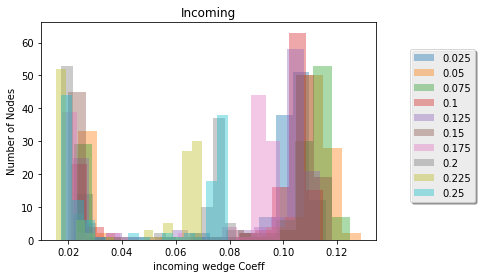

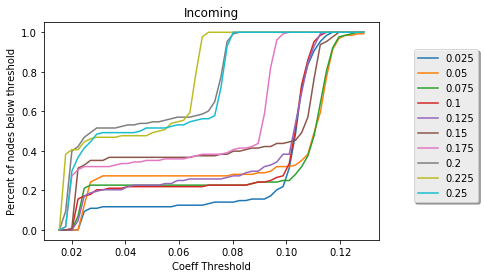

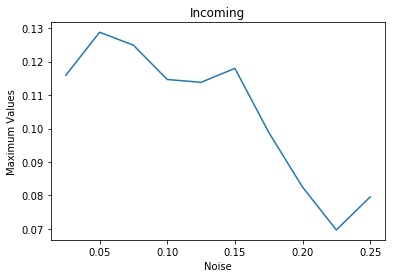

In [129]:
cumulative_hist(wedge_incoming_list, title_name = "Incoming", label_list = noise_list, 
                x_label = "incoming wedge Coeff")
cumulative_thresh(wedge_incoming_list, title_name = "Incoming", label_list = noise_list)

max_vals(wedge_incoming_list, x_axis = noise_list, title_name = "Incoming")

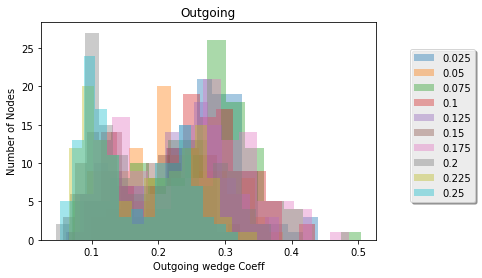

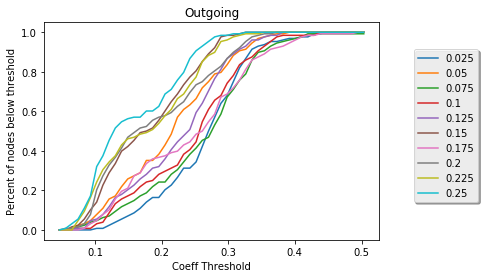

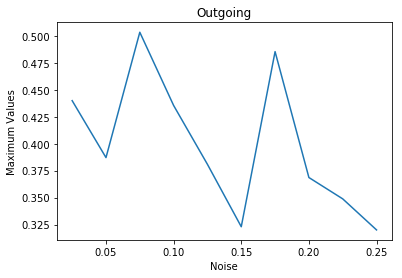

In [130]:
cumulative_hist(wedge_outgoing_list, title_name = "Outgoing", label_list = noise_list, 
                x_label = "Outgoing wedge Coeff")
cumulative_thresh(wedge_outgoing_list, title_name = "Outgoing", label_list = noise_list)

max_vals(wedge_outgoing_list, x_axis = noise_list, title_name = "Outgoing")

In [84]:
quad_list = np.array([quad_coeff(w_in.T, w_out) for (w_in, w_out) in zip(dense_weights_in, dense_weights_out)])

In [444]:
clean_quad = quad_coeff(clean_weights_in.T, clean_weights_out)

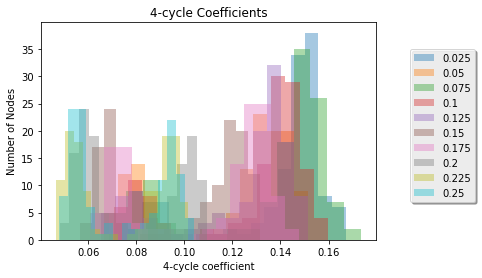

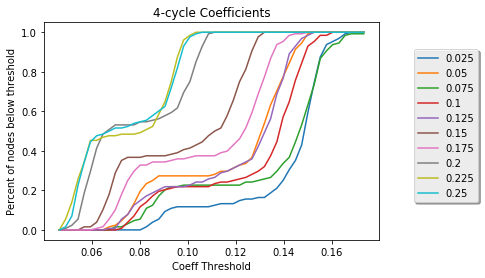

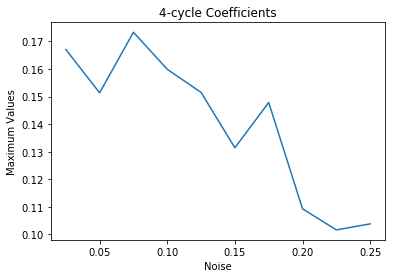

In [132]:
cumulative_hist(quad_list, title_name = "4-cycle Coefficients", label_list = noise_list, 
                x_label = "4-cycle coefficient")

cumulative_thresh(quad_list, title_name = "4-cycle Coefficients", label_list = noise_list)

max_vals(quad_list, x_axis = noise_list, title_name = "4-cycle Coefficients")

In [445]:
clean_sim_in = np.matmul(clean_weights_in, clean_weights_in.T)
clean_sim_in = clean_sim_in - np.diag(np.diag(clean_sim_in))
clean_sim_cluster_in = bct.clustering_coef_wu(clean_sim_in)

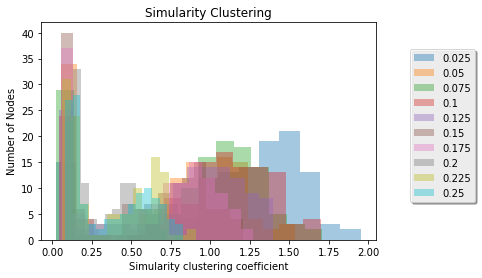

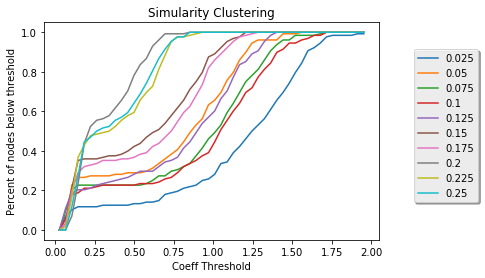

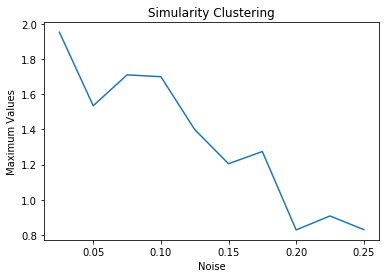

In [193]:
sim_matrix_in = np.array([np.matmul(w, w.T) for w in dense_weights_in])
sim_matrix_in = np.array([w - np.diag(np.diag(w)) for w in sim_matrix_in])
sim_clustering_in = np.array([bct.clustering_coef_wu(W) for W in sim_matrix_in])


cumulative_hist(sim_clustering_in, title_name = "Simularity Clustering", label_list = noise_list, 
                x_label = "Simularity clustering coefficient")

cumulative_thresh(sim_clustering_in, title_name = "Simularity Clustering", label_list = noise_list)

max_vals(sim_clustering_in, x_axis = noise_list, title_name = "Simularity Clustering")

In [487]:
clean_sim_out = np.matmul(clean_weights_out, clean_weights_out.T)
clean_sim_out = clean_sim_out - np.diag(np.diag(clean_sim_out))
clean_sim_cluster_out = bct.clustering_coef_wu(clean_sim_out)

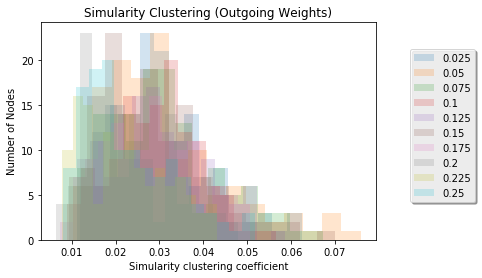

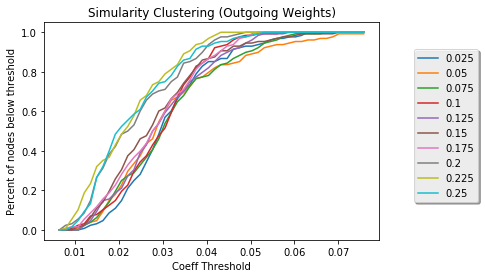

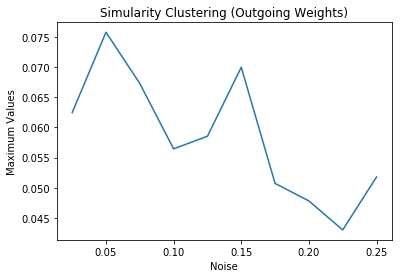

In [475]:
import bct
sim_matrix_out = np.array([np.matmul(w, w.T) for w in dense_weights_out])
sim_matrix_out = np.array([w - np.diag(np.diag(w)) for w in sim_matrix_out])
sim_clustering_out = np.array([bct.clustering_coef_wu(W) for W in sim_matrix_out])


cumulative_hist(sim_clustering_out, title_name = "Simularity Clustering (Outgoing Weights)", label_list = noise_list, 
                x_label = "Simularity clustering coefficient")

cumulative_thresh(sim_clustering_out, title_name = "Simularity Clustering (Outgoing Weights)", label_list = noise_list)

max_vals(sim_clustering_out, x_axis = noise_list, title_name = "Simularity Clustering (Outgoing Weights)")

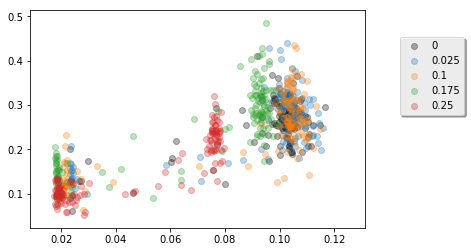

In [447]:
plt.scatter(clean_wedge_in, clean_wedge_out, label = 0, c = 'k', alpha = 0.3)
for i in range(0,10,3):
    plt.scatter(wedge_incoming_list[i],wedge_outgoing_list[i], label = noise_list[i], alpha = 0.3)


plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)
plt.show()

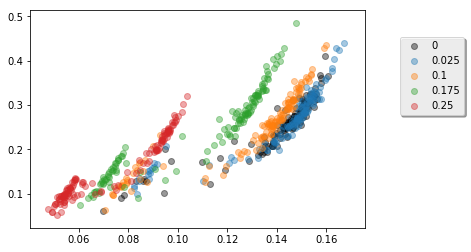

In [448]:
plt.scatter(clean_quad, clean_wedge_out, label = 0, c = 'k', alpha = 0.4)
for i in range(0,10,3):
    plt.scatter(quad_list[i],wedge_outgoing_list[i], label = noise_list[i], alpha = 0.4)
    
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)
plt.show()

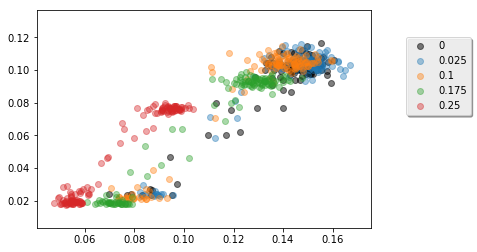

In [449]:
plt.scatter(clean_quad, clean_wedge_in, label = 0, c = 'k', alpha = 0.5)
for i in range(0,10,3):
    plt.scatter(quad_list[i],wedge_incoming_list[i], label = noise_list[i], alpha = 0.4)

plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.show()

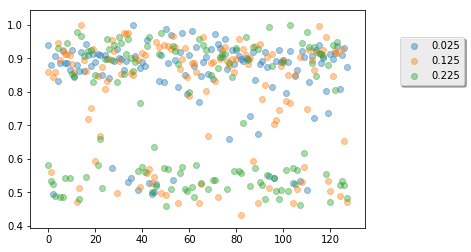

In [182]:
for i in range(0,10,4):
    lst = quad_list
    plt.scatter(range(128), lst[i]/np.max(lst[i]), label = noise_list[i], alpha = 0.4)

plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.show()

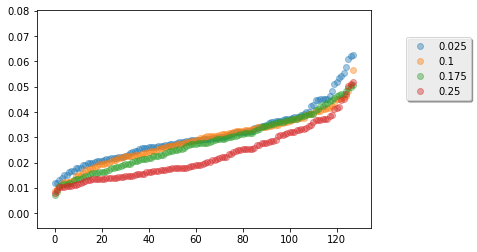

In [365]:
for i in range(0,10,3):
    lst = sim_clustering
    plt.scatter(range(128), np.sort(lst[i]), label = noise_list[i], alpha = 0.4)

plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.show()

In [219]:
dense_weights_out[0].shape

(128, 10)

In [312]:
reduced_list

array([ True, False, False,  True, False, False,  True, False, False,  True], dtype=bool)

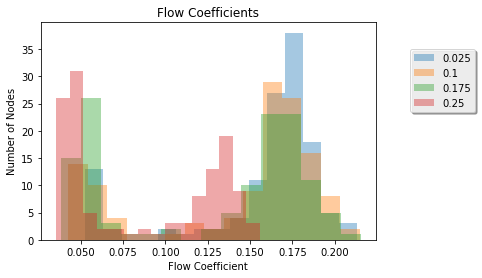

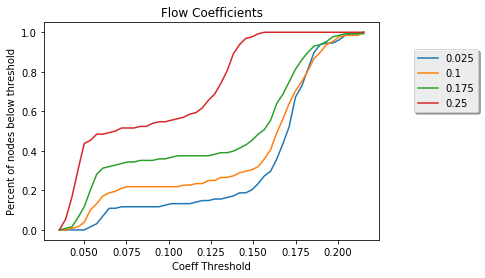

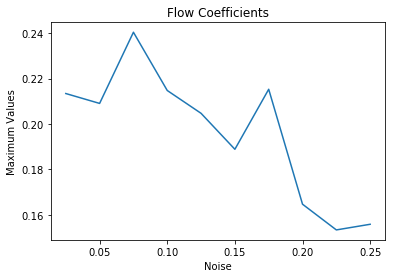

In [317]:
def flow_coeff(in_layer, out_layer):
    in_w = np.copy(in_layer)
    out_w = np.copy(out_layer)
    in_w = np.abs(in_w)
    in_w = in_w/np.max(in_w)
    out_w = np.abs(out_w)
    out_w = out_w/np.max(out_w)
    
    in_sum = np.sum(np.sqrt(in_w), axis = 1) 
    out_sum = np.sum(np.sqrt(out_w), axis = 1)
    
    return 1/(in_layer.shape[1] * out_layer.shape[1]) * np.multiply(in_sum, out_sum)


flow_list = np.array([flow_coeff(dense_weights_in[i], dense_weights_out[i]) for i in range(10)])

small = np.array([(n % 3 ==0) for n in range(10)])

cumulative_hist(flow_list[small], title_name = "Flow Coefficients", label_list = noise_list[small], 
                x_label = "Flow Coefficient")

cumulative_thresh(flow_list[small], title_name = "Flow Coefficients", label_list = noise_list[small])

max_vals(flow_list, x_axis = noise_list, title_name = "Flow Coefficients")


In [737]:
clean_flow = flow_coeff(clean_weights_in, clean_weights_out)

In [307]:
np.array([np.sum(f < 0.08) for f in flow_list])

array([15, 35, 29, 28, 28, 47, 44, 68, 62, 66])

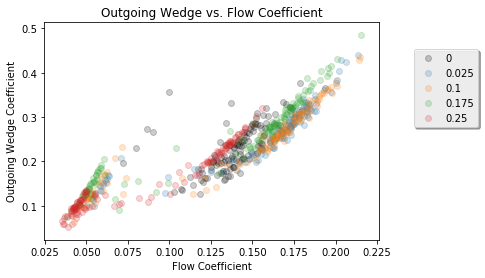

In [440]:
plt.scatter(clean_flow, clean_wedge_out, alpha = 0.2, c = 'k', label = 0)

for i in range(0,10,3):
    plt.scatter(flow_list[i], wedge_outgoing_list[i], alpha = 0.2, label = noise_list[i])
    
plt.title("Outgoing Wedge vs. Flow Coefficient")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.xlabel("Flow Coefficient")
plt.ylabel("Outgoing Wedge Coefficient")
plt.show()

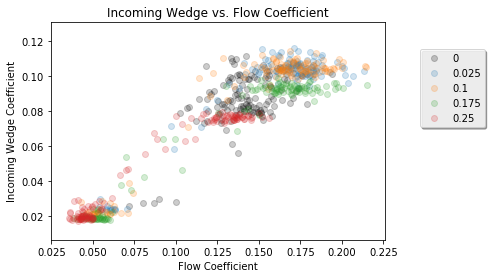

In [436]:
plt.scatter(clean_flow, clean_wedge_in, alpha = 0.2, label = 0, c = 'k')
for i in range(0,10,3):
    plt.scatter(flow_list[i], wedge_incoming_list[i], alpha = 0.2, label = noise_list[i])
    
plt.title("Incoming Wedge vs. Flow Coefficient")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.xlabel("Flow Coefficient")
plt.ylabel("Incoming Wedge Coefficient")
plt.show()

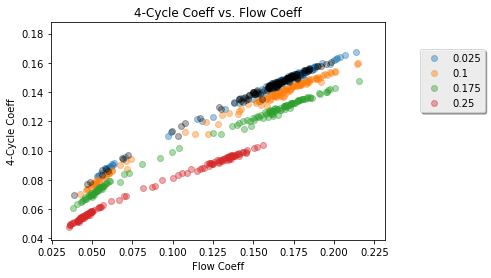

In [741]:

for i in range(0,10,3):
    plt.scatter(flow_list[i], quad_list[i], alpha = 0.4, label = noise_list[i])
    
plt.title("4-Cycle Coeff vs. Flow Coeff")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.scatter(clean_flow, clean_quad, alpha = 0.3, label = 0, c = 'k')
plt.xlabel("Flow Coeff")
plt.ylabel("4-Cycle Coeff")
plt.show()

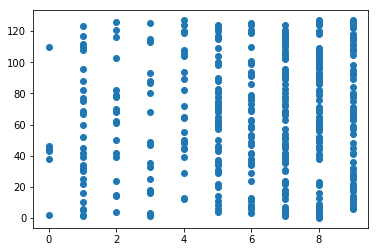

In [246]:
plt.scatter(*np.argwhere(flow_list < 0.06).T)
plt.show()

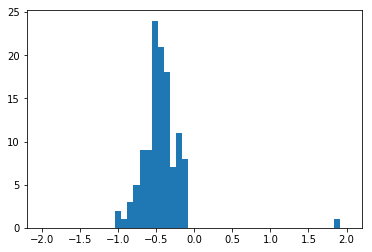

In [270]:
plt.hist(np.linalg.eig(sim_matrix[0])[0], 50, range=(-2,2))
plt.show()

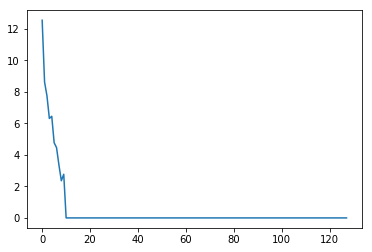

In [271]:
rawr = np.array([np.matmul(w, w.T) for w in dense_weights_out])
plt.plot(np.linalg.eig(rawr[0])[0])
plt.show()

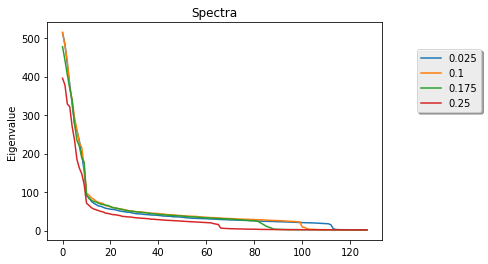

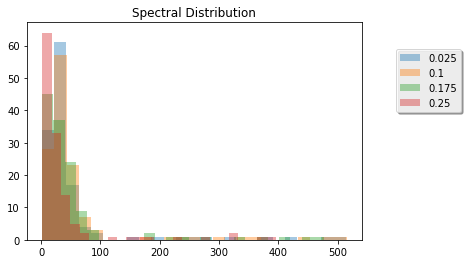

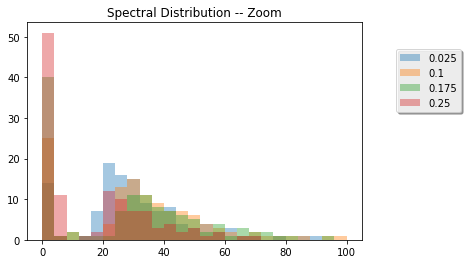

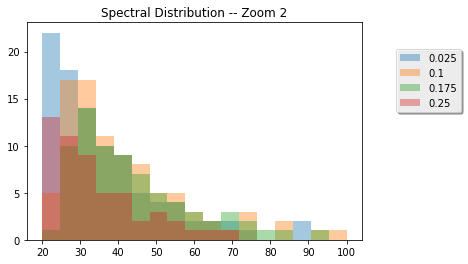

In [403]:
rawr = np.array([np.matmul(w, w.T) for w in dense_weights_in])
rawr_eig = np.array([np.linalg.eig(rawr[i])[0] for i in range(10)])

for i in range(0,10,3):
    plt.plot(-np.sort(-rawr_eig[i][:]), label = str(noise_list[i]))
    
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.title("Spectra")

plt.ylabel("Eigenvalue")
plt.show()


for i in range(0,10,3):
    plt.hist(-np.sort(-rawr_eig[i][:]), 25, label = str(noise_list[i]), alpha = 0.4)
    
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.title("Spectral Distribution")

plt.show()

for i in range(0,10,3):
    plt.hist(-np.sort(-rawr_eig[i][:]), 25, label = str(noise_list[i]), alpha = 0.4, range = (0,100))
    
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.title("Spectral Distribution -- Zoom")

plt.show()

for i in range(0,10,3):
    plt.hist(-np.sort(-rawr_eig[i][:]), 17, label = str(noise_list[i]), alpha = 0.4, range = (20,100))
    
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.title("Spectral Distribution -- Zoom 2")

plt.show()

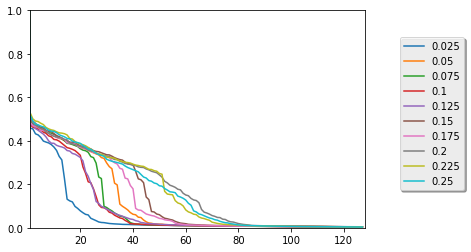

In [723]:
def vnorm(arr):
    return np.array([w/np.dot(w,w) for w in arr])



norm_test1 = np.array([w/np.dot(w,w) for w in dense_weights_in[0]])

gram_norm1 = np.matmul(norm_test1, norm_test1.T)


gram_norm_list = np.array([np.matmul(vnorm(w), vnorm(w).T) for w in dense_weights_in])
for i in range(10):
    plt.plot(-np.sort(-np.linalg.eig(gram_norm_list[i])[0]), label = str(noise_list[i]))
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
       ncol=1, fancybox=True, shadow=True)
plt.xlim(1,128)
plt.ylim(0,1)
plt.show()

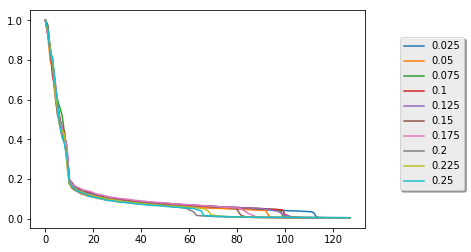

In [303]:
rawr3 = np.array([r/np.max(r) for r in rawr_eig])

for i in range(10):
    plt.plot(-np.sort(-rawr3[i][:]), label = noise_list[i], 
             label = str(noise_list[i]), alpha = 0.4, range = (20,100))
    
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)
plt.title("Normalized ")
plt.show()

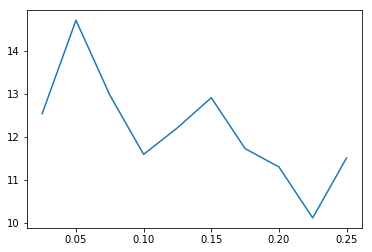

In [291]:
plt.plot(noise_list,rawr_eig.T[0])
plt.show()

In [306]:
np.linalg.eig(rawr[0])[1].shape

(128, 128)

In [381]:
def L1(arr):
    return(np.sum(np.abs(arr),axis = 1)/arr.size)

L1_in = np.array([L1(arr) for arr in dense_weights_in])
L1_out = np.array([L1(arr) for arr in dense_weights_out])
    

In [504]:
np.sum((L1_in< .0003), axis = 1)

array([15, 35, 29, 28, 29, 47, 42, 66, 60, 63])

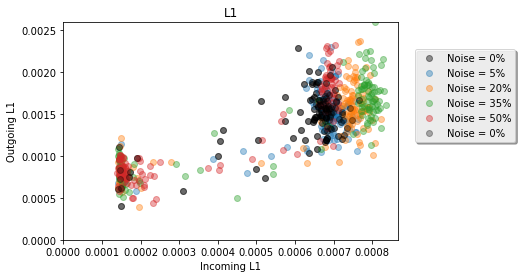

In [734]:
clean_L1_in = L1(clean_weights_in)
clean_L1_out = L1(clean_weights_out)
plt.scatter(clean_L1_in, clean_L1_out, alpha = 0.4, label = "Noise = 0%", c = 'k')

for i in range(0,10,3):
    plt.scatter(L1_in[i], L1_out[i], alpha = 0.4, label = "Noise = " + str(int(200*noise_list[i])) + "%")


plt.scatter(clean_L1_in, clean_L1_out, alpha = 0.3, label = "Noise = 0%", c = 'k')
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)

plt.title("L1")
plt.xlim(0, np.max(L1_in))
plt.ylim(0, np.max(L1_out))

plt.xlabel("Incoming L1")
plt.ylabel("Outgoing L1")
plt.show()

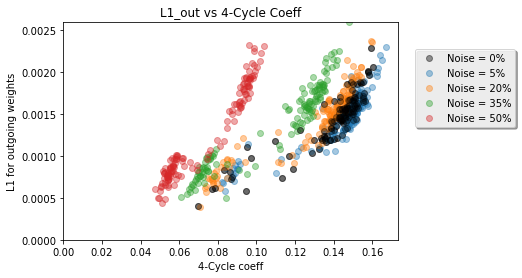

In [732]:
plt.scatter(clean_quad, clean_L1_out, alpha = 0.4, label = "Noise = 0%", c = 'k')

for i in range(0,10,3):
    plt.scatter(quad_list[i], L1_out[i], alpha = 0.4, label = "Noise = " + str(int(200*noise_list[i])) + "%")

plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)
plt.title("L1_out vs 4-Cycle Coeff")
plt.scatter(clean_quad, clean_L1_out, alpha = 0.3, label = "Noise = 0%", c = 'k')
plt.xlim(0, np.max(quad_list))
plt.ylim(0, np.max(L1_out))
plt.xlabel("4-Cycle coeff")
plt.ylabel("L1 for outgoing weights")
plt.show()

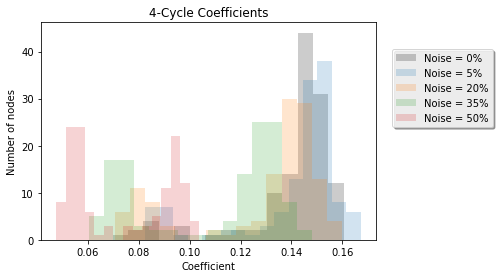

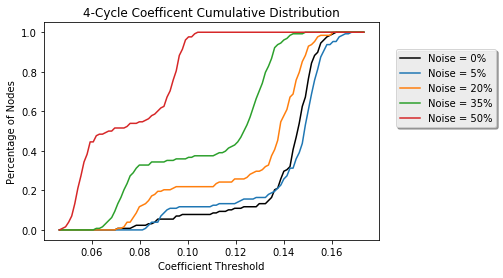

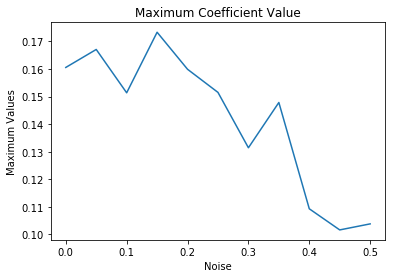

In [510]:

plt.title("4-Cycle Coefficients")
plt.hist(clean_quad, 15, alpha = 0.2, label = "Noise = 0%", color = 'k')
for i in range(0,10,3):
    plt.hist(quad_list[i], 15, alpha = 0.2, label = "Noise = " + str(int(200*noise_list[i])) + "%")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
      ncol=1, fancybox=True, shadow=True)
plt.xlabel("Coefficient")
plt.ylabel("Number of nodes")
plt.show()

    

thresh_list = np.linspace(np.min(quad_list), np.max(quad_list), 100)

clean_cumula_nodes = np.array([np.sum(clean_quad < thresh) for thresh in thresh_list])/128
plt.plot(thresh_list, clean_cumula_nodes, label = "Noise = 0%", c = 'k')

plt.title("4-Cycle Coefficent Cumulative Distribution")
for i in range(0,10,3):
    cumula_nodes = np.array([np.sum(quad_list[i] < thresh) for thresh in thresh_list])/128
    plt.plot(thresh_list, cumula_nodes, label = "Noise = " + str(int(200*noise_list[i])) + "%")
plt.xlabel("Coefficient Threshold")
plt.ylabel("Percentage of Nodes")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
      ncol=1, fancybox=True, shadow=True)
plt.show()
    


plt.title("Maximum Coefficient Value")
plt.plot(2*np.append([0], np.copy(noise_list)), np.max(np.append([clean_quad], quad_list, axis = 0), axis = 1))
plt.xlabel("Noise")
plt.ylabel("Maximum Values")
plt.show()

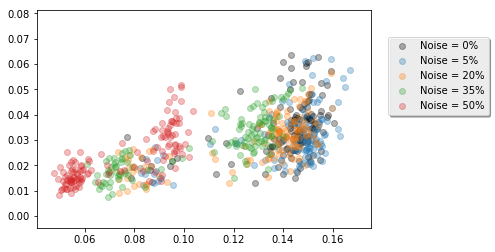

In [494]:
plt.scatter(clean_quad, clean_sim_cluster_out, alpha = 0.3, c='k', label = "Noise = 0%")
for i in range(0,10,3):
    plt.scatter(quad_list[i], sim_clustering_out[i], alpha = 0.3,
                label = "Noise = " + str(int(200*noise_list[i])) + "%")

plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
      ncol=1, fancybox=True, shadow=True)
plt.show()

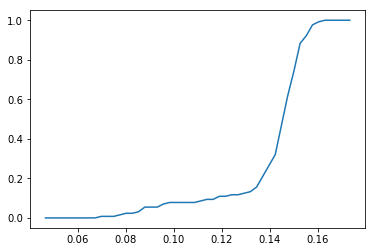

In [505]:
plt.plot(thresh_list, clean_cumula_nodes)

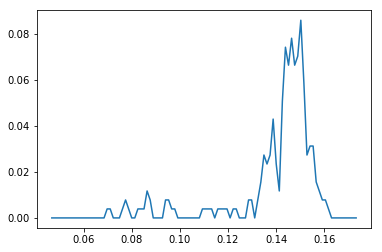

In [513]:
plt.plot(thresh_list, np.gradient(clean_cumula_nodes))

In [515]:
cumula_nodes

array([ 0.       ,  0.0078125,  0.015625 ,  0.0390625,  0.0703125,
        0.1328125,  0.2109375,  0.2734375,  0.34375  ,  0.3828125,
        0.4453125,  0.4453125,  0.4765625,  0.484375 ,  0.484375 ,
        0.4921875,  0.5      ,  0.5      ,  0.515625 ,  0.515625 ,
        0.515625 ,  0.515625 ,  0.5234375,  0.5390625,  0.5390625,
        0.5390625,  0.546875 ,  0.546875 ,  0.5546875,  0.5625   ,
        0.578125 ,  0.5859375,  0.6015625,  0.6171875,  0.625    ,
        0.671875 ,  0.703125 ,  0.7578125,  0.8046875,  0.8828125,
        0.9140625,  0.9609375,  0.9765625,  0.9765625,  0.9921875,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.    

In [516]:
 cumula_list = np.array([np.array([np.sum(quad_list[i] < thresh) for thresh in thresh_list])/128 for i in range(10)])

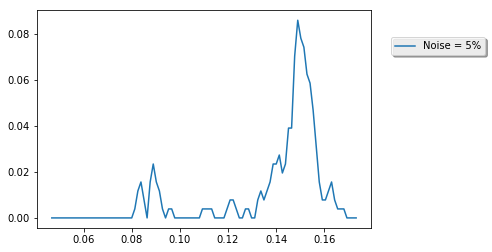

In [527]:
for i in range(0,10,10):
    plt.plot(thresh_list, np.gradient(cumula_list[i]),label = "Noise = " + str(int(200*noise_list[i])) + "%")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
      ncol=1, fancybox=True, shadow=True)
plt.show()

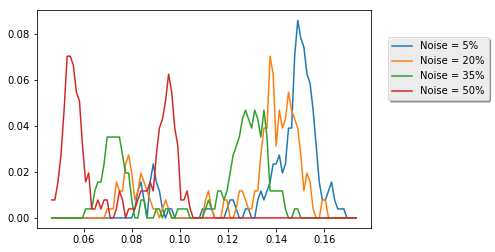

In [528]:
for i in range(0,10,3):
    plt.plot(thresh_list, np.gradient(cumula_list[i]),label = "Noise = " + str(int(200*noise_list[i])) + "%")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
      ncol=1, fancybox=True, shadow=True)
plt.show()

In [579]:
from scipy.signal import savgol_filter as savgol
from scipy.signal import find_peaks_cwt

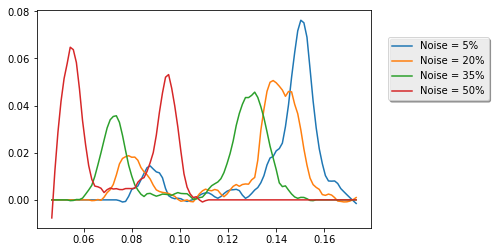

In [576]:
for i in range(0,10,3):
    plt.plot(thresh_list, savgol(np.gradient(cumula_list[i]), window_length = 11, polyorder = 2),label = "Noise = " + str(int(200*noise_list[i])) + "%")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
      ncol=1, fancybox=True, shadow=True)
plt.show()

# plt.plot(savgol(np.gradient(clean_cumula_nodes), window_length = 21, polyorder = 2))

In [578]:
rawr = savgol(np.gradient(cumula_list[i]), window_length = 11, polyorder = 2)

np.min(np.argwhere(rawr < (0.1* np.max(rawr))))

0

In [598]:
print(find_peaks_cwt(rawr, np.linspace(0.01,0.04,10)))
print(find_peaks_cwt(np.gradient(cumula_list[-1]), np.linspace(0.01,0.4,100)))

[17 20 23 26 46 49]
[12 15 16 22 25 29 32 38 44]


/Users/nzolman/anaconda3/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


In [696]:
find_peaks_cwt(cumula_list[-1], np.linspace(0.010,.064,1000))

array([], dtype=float64)

/Users/nzolman/anaconda3/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
/Users/nzolman/anaconda3/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: invalid value encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


0.023319128787878868

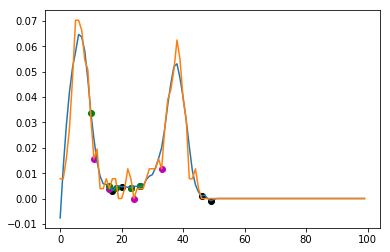

In [611]:
plt.plot(rawr)
plt.plot(np.gradient(cumula_list[-1]))
for i in find_peaks_cwt(rawr, np.linspace(0.01,0.04,1000)):
    plt.scatter(*[i, rawr[i]], c = 'k')
rawr2 = np.gradient(cumula_list[-1])
for i in find_peaks_cwt(rawr2, np.linspace(0.01,0.04,1000)):
    plt.scatter(*[i, rawr2[i]], c = 'm')

for i in find_peaks_cwt(cumula_list[-1], np.linspace(0.01,0.4,1000)):   
    plt.scatter(*[i, rawr[i]], c = 'g')
rawr[11]

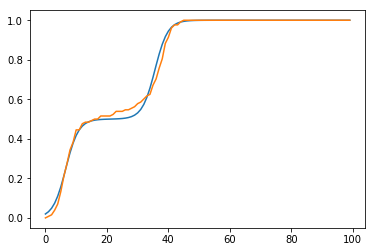

In [670]:
def sigmoid(x, x0, x1, k):
    y = 0.5*(1 / (1 + np.exp(-k*(x-x0))) + 1 / (1 + np.exp(-k*(x-x1))))
    return y

s1 = sigmoid(np.linspace(0,10, 100), .67, 3.6, 4.75)


plt.plot(s1)
plt.plot(cumula_list[-1]/np.max(cumula_list[-1]))
# plt.plot(s2)
# plt.plot((s1+s2)/2)

In [661]:
from scipy.optimize import curve_fit

xdata = np.array([0.0,   1.0,  3.0, 4.3, 7.0,   8.0,   8.5, 10.0, 12.0])
ydata = np.array([0.01, 0.02, 0.04, 0.11, 0.43,  0.7, 0.89, 0.95, 0.99])

popt, pcov = curve_fit(sigmoid, range(100), cumula_list[-1]/np.max(cumula_list[-1]))
print(popt)

[ 36.40842654   6.76675235   0.47147129]


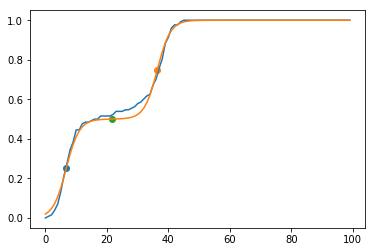

In [675]:
plt.plot(cumula_list[-1]/np.max(cumula_list[-1]))
plt.plot(sigmoid(range(100), *popt))
plt.scatter(*[6.7667, sigmoid(6.7667, *popt)])
plt.scatter(*[36.408, sigmoid(36.408, *popt)])
plt.scatter(*[(6.7667+36.408)/2, sigmoid((6.7667+36.408)/2, *popt)])

21.587589444262814

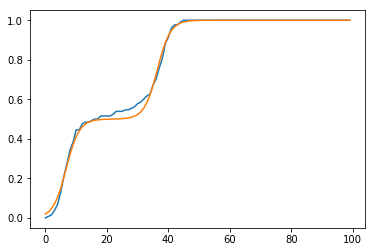

In [690]:
i = -1
popt2, pcov = curve_fit(sigmoid, range(100), cumula_list[i]/np.max(cumula_list[i]))
plt.plot(cumula_list[i]/np.max(cumula_list[i]))
plt.plot(sigmoid(range(100), *popt2))
(popt2[0]+popt2[1])/2
# plt.scatter(*[6.7667, sigmoid(6.7667, *popt)])
# plt.scatter(*[36.408, sigmoid(36.408, *popt)])
# plt.scatter(*[(6.7667+36.408)/2, sigmoid((6.7667+36.408)/2, *popt)])

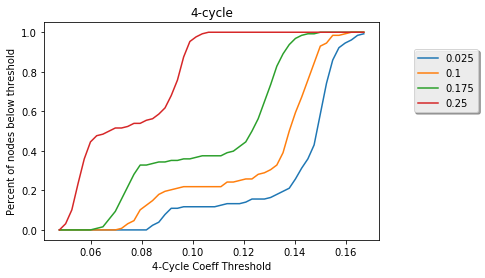

In [782]:
small = np.array([i%3 == 0 for i in range(10)])
cumulative_thresh(quad_list[small], "4-cycle", label_list = noise_list[small], 
                  x_label = "4-Cycle Coeff Threshold" , y_label = "Percent of nodes below threshold")

In [912]:
def prune_model(model, bool_arr, layer_in = -4):
    bias_index = layer_in + 1
    layer_out = layer_in + 2
    weights = model.get_weights()
    weights[layer_in].T[bool_arr] = 0* weights[layer_in].T[bool_arr]
    weights[layer_out][bool_arr] = 0 * weights[layer_out][bool_arr]
    weights[bias_index][bool_arr] = 0* weights[bias_index][bool_arr]
    config = model.get_config()
    from keras.models import Sequential
    model2 = Sequential.from_config(config)
    model2.set_weights(weights)
    model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model2

In [909]:
np.sum(quad_list[0] < 0.154)/128

0.8046875

In [910]:
test_model = prune_model(model_list[0], quad_list[0] < 0.154, layer_in = -4)

In [876]:
test_model.layers[-3].get_weights()[0].T 

array([[-0.,  0., -0., ...,  0.,  0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0., -0., ..., -0., -0., -0.],
       [ 0., -0.,  0., ..., -0.,  0.,  0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

In [841]:
test = np.copy(model_list[0].get_weights()[-4])

In [829]:
test.T[L1_in[0] < 0.0007] = 0 * test.T[L1_in[0] < 0.0007] 

In [830]:
test

array([[ 0.0093045 , -0.        ,  0.        , ..., -0.08361514,
        -0.        , -0.        ],
       [ 0.18273796,  0.        , -0.        , ...,  0.03029078,
         0.        ,  0.        ],
       [ 0.04322074,  0.        ,  0.        , ..., -0.06051045,
        -0.        ,  0.        ],
       ..., 
       [-0.0069549 ,  0.        ,  0.        , ...,  0.11919059,
         0.        ,  0.        ],
       [ 0.13728067,  0.        , -0.        , ..., -0.03006415,
         0.        , -0.        ],
       [ 0.11561155, -0.        ,  0.        , ..., -0.03033528,
        -0.        ,  0.        ]], dtype=float32)

In [761]:
test[L1_in[0] < 0.0006] = 0.0

In [869]:
test_model.get_weights()[-2].shape

(128, 10)

In [870]:
from keras.datasets import mnist
from keras.utils import np_utils
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

  
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [877]:
test_model = prune_model(model_list[-1], quad_list[-1] < 0.09, layer = -4)

TypeError: prune_model() got an unexpected keyword argument 'layer'

In [905]:
score = model_list[0].evaluate(X_test, Y_test, verbose=0)
print(score)
# score = test_model.evaluate(X_test, y_test, verbose=0)
# print(score)

[0.03269867235878901, 0.99160000000000004]


In [911]:
score = test_model.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.34955809869766236, 0.91749999999999998]
